# MLPClassifier

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [3]:
from sklearn.datasets import fetch_20newsgroups


train_data = fetch_20newsgroups(subset='train')
val_data = fetch_20newsgroups(subset='test')

len(train_data['data']), len(val_data['data'])

(11314, 7532)

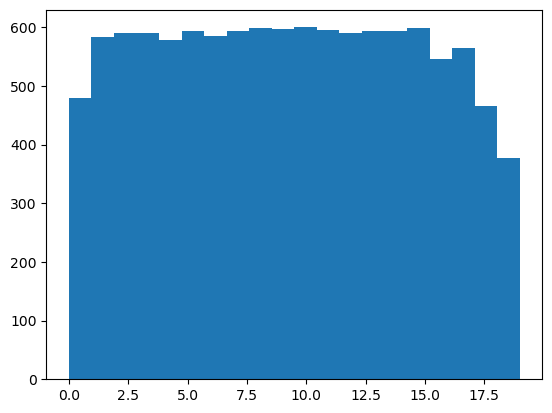

In [4]:
plt.hist(train_data['target'], bins=20)
None

## Text preprocessing

In [5]:
! pip install -qq spacy

In [6]:
from tqdm import tqdm
import re
from collections import Counter
from spacy.lang.en import stop_words


import nltk
from nltk.corpus import words
nltk.download('words')


DICT_WORDS_COUNT = 1000
stopwords = stop_words.STOP_WORDS

[nltk_data] Downloading package words to /Users/ktann/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [7]:
english_words_corpora = words.words()
len(english_words_corpora)

236736

In [8]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

In [9]:
def clean_text(text):

    if 'Lines:' in text:
        start = text.index('Lines:') + 5
        text = text[start:]

    text = text.lower()

    text = re.sub(r'[\w\d.]+@[\w\d]+.[\w\d]+', ' ', text)
    text = re.sub(r'(http|https)://[\w\d/.]+', ' ', text)

    text = re.sub(r'[^a-z]', ' ', text)

    text = re.sub(r'([^\w]|[-_])+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'(.)\1{2,}', r'\1', text)
    text = re.sub(r'\s+', ' ', text)

    text = text.strip()
    
    # words = [
    #     w for w in text.split() \
    #         if len(w) > 3 and \
    #             w not in stopwords and \
    #             w in english_words_corpora
    # ]
    
    words = [
        stemmer.stem(w) for w in text.split() \
            if len(w) > 3 and \
                w not in stopwords
    ]

    

    return ' '.join(words)

In [10]:
text = train_data['data'][0]
print(text)
print()

print(clean_text(text))

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----






wonder enlighten door sport look late earli call bricklin door small addit bumper separ rest bodi know tellm model engin spec year product histori info funki look mail thank brought neighborhood lerxst


In [11]:
from random import randint, seed
import warnings
warnings.filterwarnings('ignore')

In [12]:
seed(4242)
samples1000 = list(filter(lambda it: randint(0, 9) == 0, zip(train_data['data'], train_data['target'])))
# samples1000 = list(zip(train_data['data'], train_data['target']))

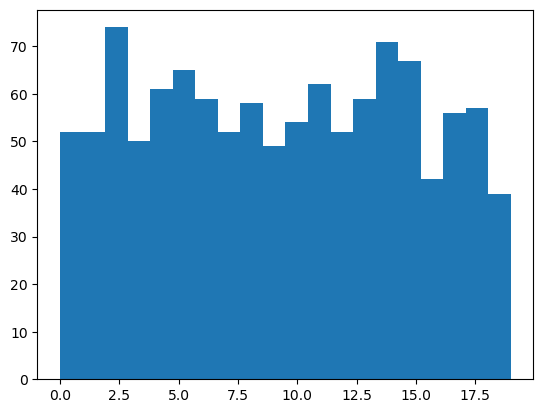

In [13]:
texts1000, targets1000 = zip(*samples1000)
plt.hist(targets1000, bins=20)
None

In [14]:
clean_train_texts = [
    clean_text(text) for text, target in tqdm(samples1000, desc='Train texts')
]

Train texts:   0%|          | 0/1131 [00:00<?, ?it/s]

Train texts: 100%|██████████| 1131/1131 [00:00<00:00, 1234.09it/s]


## LSI

In [15]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from gensim.utils import simple_preprocess
from sklearn.feature_extraction.text import TfidfVectorizer

In [16]:
# Preprocess the text data and create a list of tokenized documents
tokenized_documents = [simple_preprocess(text) for text in clean_train_texts]

# Create a dictionary mapping of words to unique IDs
dictionary = corpora.Dictionary(tokenized_documents)

# Create a Bag of Words (BoW) representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_documents]

In [17]:
# Create a TF-IDF model
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [18]:
# Train the LSI model (Latent Semantic Indexing)
lsi_model = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=20)

# Print the top topics and their top words
lsi_topics = lsi_model.print_topics(num_topics=20, num_words=10)
for topic in lsi_topics:
    print(topic)

# Get the document vectors
document_topic_vectors = []
for doc_bow in corpus_tfidf:
    document_topic_vector = lsi_model[doc_bow]
    document_topic_vectors.append(document_topic_vector)

# Get topic vectors for multiple documents
for i, doc_idx in enumerate([0, 1, 2, 3, 4], start=1):
    doc_bow = corpus_tfidf[doc_idx]
    document_topic_vector = lsi_model[doc_bow]
    print(f"Document {doc_idx}:")
    print(f"Topic Vector: {document_topic_vector}") 
    print(f'Doc vec len: {len(document_topic_vector)}')
    print()

(0, '0.141*"window" + 0.117*"peopl" + 0.099*"think" + 0.097*"know" + 0.097*"like" + 0.091*"system" + 0.087*"time" + 0.087*"file" + 0.087*"post" + 0.085*"thank"')
(1, '0.455*"window" + 0.212*"file" + 0.130*"card" + -0.122*"christian" + 0.120*"thank" + 0.115*"program" + 0.104*"driver" + -0.101*"peopl" + 0.100*"screen" + 0.098*"drive"')
(2, '-0.395*"window" + 0.267*"drive" + 0.197*"game" + -0.171*"file" + -0.169*"moral" + -0.152*"christian" + -0.114*"jesus" + 0.106*"control" + 0.106*"card" + -0.103*"motif"')
(3, '-0.419*"game" + 0.285*"drive" + -0.188*"window" + -0.171*"team" + -0.165*"hockey" + -0.128*"player" + -0.116*"season" + -0.115*"divis" + -0.113*"pick" + 0.105*"card"')
(4, '-0.212*"moral" + 0.201*"armenian" + 0.198*"govern" + -0.197*"game" + -0.192*"christian" + -0.172*"jesus" + -0.153*"drive" + 0.149*"turkish" + 0.112*"secur" + -0.099*"believ"')
(5, '0.351*"moral" + -0.262*"drive" + -0.231*"armenian" + -0.172*"turkish" + -0.172*"window" + -0.105*"armenia" + 0.096*"system" + 0.09

In [19]:
df = pd.DataFrame(targets1000, columns=['target'])
df

,target
0,4
1,19
2,12
3,6
4,17
...,...
1126,15
1127,8
1128,2
1129,5


In [20]:
docs_vectors = []

for doc_idx in tqdm(range(len(df))):
    doc_bow = corpus_tfidf[doc_idx]
    document_topic_vector = lsi_model[doc_bow]

    if document_topic_vector:
        _, vec = zip(*document_topic_vector)
    else:
        vec = [None] * 20

    docs_vectors.append(vec)

100%|██████████| 1131/1131 [00:00<00:00, 10227.89it/s]


In [21]:
len(docs_vectors)

1131

In [22]:
df[[f'vec{i}' for i in range(20)]] = docs_vectors

In [23]:
df

,target,vec0,vec1,vec2,vec3,vec4,vec5,vec6,vec7,vec8,...,vec10,vec11,vec12,vec13,vec14,vec15,vec16,vec17,vec18,vec19
0,4,0.213519,0.049085,0.054119,0.001319,-0.038331,0.011443,0.051284,0.006085,-0.006518,...,-0.003908,0.014019,-0.014619,-0.005602,-0.020301,-0.017284,-0.018499,0.067478,0.061358,0.031735
1,19,0.212202,-0.129295,-0.199675,0.090531,-0.196327,0.206528,-0.296424,-0.024824,0.061968,...,-0.004112,-0.003753,0.004088,0.052148,-0.004409,0.082917,-0.020000,-0.049316,-0.019692,0.038092
2,12,0.100454,0.034991,0.038800,0.021921,0.004488,0.026408,0.024598,-0.032254,0.011798,...,-0.008577,-0.003861,-0.004361,0.003696,0.003589,-0.045067,0.041572,-0.014018,0.040610,0.026670
3,6,0.120482,0.008390,0.056696,0.017963,0.023821,0.012128,0.012940,-0.013840,-0.014715,...,0.014149,-0.030290,0.000447,-0.015409,0.017837,-0.010844,-0.025810,0.013100,0.054031,0.048575
4,17,0.125665,-0.102068,-0.027775,0.013751,0.109926,-0.124977,-0.056995,0.018263,-0.013237,...,0.018483,0.304120,-0.110856,0.061933,-0.034271,-0.013176,-0.048014,-0.039285,0.118260,0.055082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126,15,0.123509,-0.075571,-0.033582,0.010767,-0.034287,-0.031489,0.044561,-0.000516,-0.011507,...,-0.010570,-0.011698,-0.020955,0.047598,0.002057,0.010449,0.020041,-0.030495,0.020575,0.039639
1127,8,0.145778,-0.018561,0.028864,0.006147,0.002931,0.007123,0.050346,-0.027783,-0.036811,...,-0.016736,-0.042393,-0.039147,-0.023241,-0.010734,-0.018000,-0.038081,-0.017974,0.084129,0.033992
1128,2,0.094354,0.027313,0.024316,-0.004189,0.030735,0.044133,0.069834,-0.005385,0.082311,...,-0.004090,0.031712,0.017471,0.041308,0.058265,-0.032695,0.049186,0.010443,0.002450,0.048088
1129,5,0.096025,0.035761,-0.019440,0.000505,-0.011201,0.027691,0.007597,0.029282,0.023071,...,-0.005103,0.008536,0.011845,-0.015890,0.024795,0.002445,0.001371,0.001063,0.020222,-0.011028


## Training

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [29]:
for md in np.linspace(5, 12, 8):

    md = int(md)

    X_train, X_val, y_train, y_val = train_test_split(
        df.drop('target', axis=1),
        df['target'],
        test_size=0.2,
        shuffle=True,
        random_state=42,
    )
                
    clf = DecisionTreeClassifier(
        max_depth=md,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f'max_depth={md:4d}    =>    acc={acc:.4f}, macro-f1={f1:.4f}')
    print()

max_depth=   5    =>    acc=0.3425, macro-f1=0.2845

max_depth=   6    =>    acc=0.4030, macro-f1=0.3625

max_depth=   7    =>    acc=0.4600, macro-f1=0.4461

max_depth=   8    =>    acc=0.5077, macro-f1=0.5077

max_depth=   9    =>    acc=0.5378, macro-f1=0.5440

max_depth=  10    =>    acc=0.5572, macro-f1=0.5586

max_depth=  11    =>    acc=0.5616, macro-f1=0.5510

max_depth=  12    =>    acc=0.5727, macro-f1=0.5641



In [30]:
! pip install -qq catboost

## GB

In [31]:
from catboost import CatBoostClassifier

In [32]:
X_train, X_val, y_train, y_val = train_test_split(
    df.drop('target', axis=1),
    df['target'],
    test_size=0.2,
    shuffle=True,
    random_state=42,
)
            
clf = CatBoostClassifier(
    iterations=2500,
    verbose=200,
)
clf.fit(
    X=X_train,
    y=y_train,
    eval_set=(X_val, y_val),
    early_stopping_rounds=100,
)

y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

print()
print(f'acc={acc:.4f}, macro-f1={f1:.4f}')

Learning rate set to 0.079515
0:	learn: 2.7365640	test: 2.7405589	best: 2.7405589 (0)	total: 92.6ms	remaining: 3m 51s
200:	learn: 0.7026193	test: 0.9129680	best: 0.9129680 (200)	total: 4.21s	remaining: 48.2s
400:	learn: 0.5237178	test: 0.8684667	best: 0.8684314 (399)	total: 8.13s	remaining: 42.6s
600:	learn: 0.4134982	test: 0.8524040	best: 0.8524040 (600)	total: 12.1s	remaining: 38.4s
800:	learn: 0.3359766	test: 0.8448679	best: 0.8447868 (795)	total: 16.1s	remaining: 34.2s
1000:	learn: 0.2822853	test: 0.8418315	best: 0.8414281 (984)	total: 20.1s	remaining: 30.2s
1200:	learn: 0.2397010	test: 0.8400474	best: 0.8397667 (1160)	total: 24.8s	remaining: 26.8s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8397212129
bestIteration = 1208

Shrink model to first 1209 iterations.

acc=0.7269, macro-f1=0.7162


## RF

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [39]:
for md in [8, 16, 32, 64]:

    md = int(md)

    dff = df.dropna()

    X_train, X_val, y_train, y_val = train_test_split(
        dff.drop('target', axis=1),
        dff['target'],
        test_size=0.2,
        shuffle=True,
        random_state=42,
    )
                
    clf = RandomForestClassifier(
        max_depth=md,
        random_state=42,
    )
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average='macro')

    print(f'max_depth={md:4d}    =>    acc={acc:.4f}, macro-f1={f1:.4f}')
    print()

max_depth=   8    =>    acc=0.6217, macro-f1=0.6034

max_depth=  16    =>    acc=0.6854, macro-f1=0.6751

max_depth=  32    =>    acc=0.6867, macro-f1=0.6747

max_depth=  64    =>    acc=0.6850, macro-f1=0.6731



## AB

In [35]:
from sklearn.ensemble import AdaBoostClassifier

In [40]:
X_train, X_val, y_train, y_val = train_test_split(
    dff.drop('target', axis=1),
    dff['target'],
    test_size=0.2,
    shuffle=True,
    random_state=42,
)
            
clf = AdaBoostClassifier(
    random_state=42,
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

print(f'acc={acc:.4f}, macro-f1={f1:.4f}')
print()

acc=0.3717, macro-f1=0.3382



## MLP

In [25]:
from sklearn.neural_network import MLPClassifier

In [27]:
dff = df.dropna()

X_train, X_val, y_train, y_val = train_test_split(
    dff.drop('target', axis=1),
    dff['target'],
    test_size=0.2,
    shuffle=True,
    random_state=42,
)

In [41]:
for hls in [5, 10, 20, 30]:
    for act in ['identity', 'logistic', 'tanh', 'relu']:
        clf = MLPClassifier(hls, act, random_state=42)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        print(f'hls: {hls:>2}, act: {act:8s};   acc={acc:.4f}, f1={f1:.4f}')

hls:  5, act: identity;   acc=0.2599, f1=0.2085
hls:  5, act: logistic;   acc=0.0661, f1=0.0102
hls:  5, act: tanh    ;   acc=0.2775, f1=0.2282
hls:  5, act: relu    ;   acc=0.2511, f1=0.1872
hls: 10, act: identity;   acc=0.4317, f1=0.3631
hls: 10, act: logistic;   acc=0.1806, f1=0.0781
hls: 10, act: tanh    ;   acc=0.4449, f1=0.3693
hls: 10, act: relu    ;   acc=0.1982, f1=0.1087
hls: 20, act: identity;   acc=0.4978, f1=0.4456
hls: 20, act: logistic;   acc=0.2599, f1=0.1684
hls: 20, act: tanh    ;   acc=0.5154, f1=0.4591
hls: 20, act: relu    ;   acc=0.4493, f1=0.3883
hls: 30, act: identity;   acc=0.5286, f1=0.4941
hls: 30, act: logistic;   acc=0.2952, f1=0.2088
hls: 30, act: tanh    ;   acc=0.5286, f1=0.4726
hls: 30, act: relu    ;   acc=0.4890, f1=0.4437


In [ ]:
clf = AdaBoostClassifier(
    random_state=42,
)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='macro')

print(f'acc={acc:.4f}, macro-f1={f1:.4f}')
print()